In [1]:
import sys
import os
from datetime import datetime
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
pd.set_option('display.max_rows', None)
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor

In [2]:
sys.path.append(os.path.abspath('../src'))
from lib import (
    train_and_evaluate_models,
    convert_results_to_dataframe,
    create_eui_comparison_plots,
    evaluate_model_strategies,
    calculate_average_metrics,
    create_error_distribution_plots,
    grid_search_best_params
)

In [3]:
output_path = "../data/03_processed/merged_df.csv"
merged_df = pd.read_csv(output_path)
merged_df = merged_df.rename(columns={'total_year': 'hdd_total_year'})

# GDP per capita
merged_df['GDP_per_capita'] = merged_df['GDP_2022'] / merged_df['Population_2023']

# Delete Taiwan (temporal)
merged_df = merged_df[merged_df['Country'] != 'Taiwan']

#np.random.seed(123)
#merged_df['is_train'] = np.random.choice([1, 0], size=len(merged_df), p=[0.8, 0.2])

# Train / Test

In [4]:
train_test_split_original_data_path = "../data/03_processed/train_test_split_original_data.csv"
train_test_split_original_data = pd.read_csv(train_test_split_original_data_path)

train_test_split_new_data_path = "../data/03_processed/train_test_split_new_data.csv"
train_test_split_new_data = pd.read_csv(train_test_split_new_data_path)

train_test_split = pd.concat([train_test_split_original_data, train_test_split_new_data], ignore_index=True)

merged_df = merged_df.merge(train_test_split, on=['index', 'geonameid'], how='left')

# We want to keep original data 
merged_df = merged_df[merged_df["source"] == "World Bank CURB"]

In [5]:
features = [
    "hdd_total_year", 
    "cdd_total_year", 
    "GDP_per_capita", 
    "Urbanization_Rate_2022",
    #"latitude",
    #"longitude",  
    "Paris_Agreement",
    "Subnational HDI", 
    "Educational index", 
    "Income index",
    "2m_temperature_2023_avg",
    "2m_dewpoint_temperature_2023_avg",
    "total_precipitation_2023",
    "longitude_sin", 
    "longitude_cos", 
    "latitude_sin", 
    "latitude_cos",  
    "population_density"
]

feature_abbreviations = {
    "hdd_total_year": "HDD",
    "cdd_total_year": "CDD", 
    "GDP_per_capita": "GDP",
    "Urbanization_Rate_2022": "URB",
   # "latitude": "Lat",
   # "longitude": "Long",
    "Paris_Agreement": "Paris",
    "Subnational HDI": "HDI", 
    "Educational index": "EDU" , 
    "Income index": "Income",
    "2m_temperature_2023_avg": "Temp",
    "2m_dewpoint_temperature_2023_avg": "Dew",
    "total_precipitation_2023": "Precip",
    "longitude_sin": "Long_Sin", 
    "longitude_cos": "Long_Cos", 
    "latitude_sin": "Lat_Sin", 
    "latitude_cos": "Lat_Cos",  
    "population_density": "Pop_Dens"
}

target_columns = [
    "Residential EUI (kWh/m2/year)",
    "Non-residential EUI (kWh/m2/year)"
]

regions = ['Asia & Oceania', 'Europe', 'Africa', 'Central and South America', 'Northern America']


# CatBoost - Grid Serach

In [6]:
# Define parameter grid for CatBoost
cat_param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bylevel': [0.7, 0.9],
    'l2_leaf_reg': [1, 3, 5],
    'random_seed': [42],
    'bootstrap_type': ['Bernoulli'],
    'loss_function': ['MAPE'],   
    'eval_metric': ['MAPE'],  
    'verbose': [False]
}

# Run grid search with cross-validation
cat_best_params, cat_best_score, cat_all_results = grid_search_best_params(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_class=CatBoostRegressor,
    param_grid=cat_param_grid,
    feature_abbreviations=feature_abbreviations
)

# Store the best parameters
cat_params = cat_best_params

# Save the grid search results
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
cat_grid_search_results = convert_results_to_dataframe(cat_all_results, features)
cat_grid_search_results.to_csv(f'../results/gridsearch/{timestamp}_cat_grid_search_results.csv')

Evaluating combination 1/3: {'iterations': 100, 'verbose': False}
Strategy 'within_domain' - Overall Average MAPE: 12.71%
Strategy 'cross_domain' - Overall Average MAPE: 22.33%
Strategy 'all_domain' - Overall Average MAPE: 13.58%
Evaluating combination 2/3: {'iterations': 200, 'verbose': False}
Strategy 'within_domain' - Overall Average MAPE: 12.61%
Strategy 'cross_domain' - Overall Average MAPE: 21.91%
Strategy 'all_domain' - Overall Average MAPE: 13.24%
Evaluating combination 3/3: {'iterations': 300, 'verbose': False}
Strategy 'within_domain' - Overall Average MAPE: 12.70%
Strategy 'cross_domain' - Overall Average MAPE: 21.49%
Strategy 'all_domain' - Overall Average MAPE: 13.18%

=== Best Parameters for cross_domain strategy ===
{'iterations': 300, 'verbose': False}
Cross-domain Average CV MAPE: 21.49%


### CatBoost - Within Domain

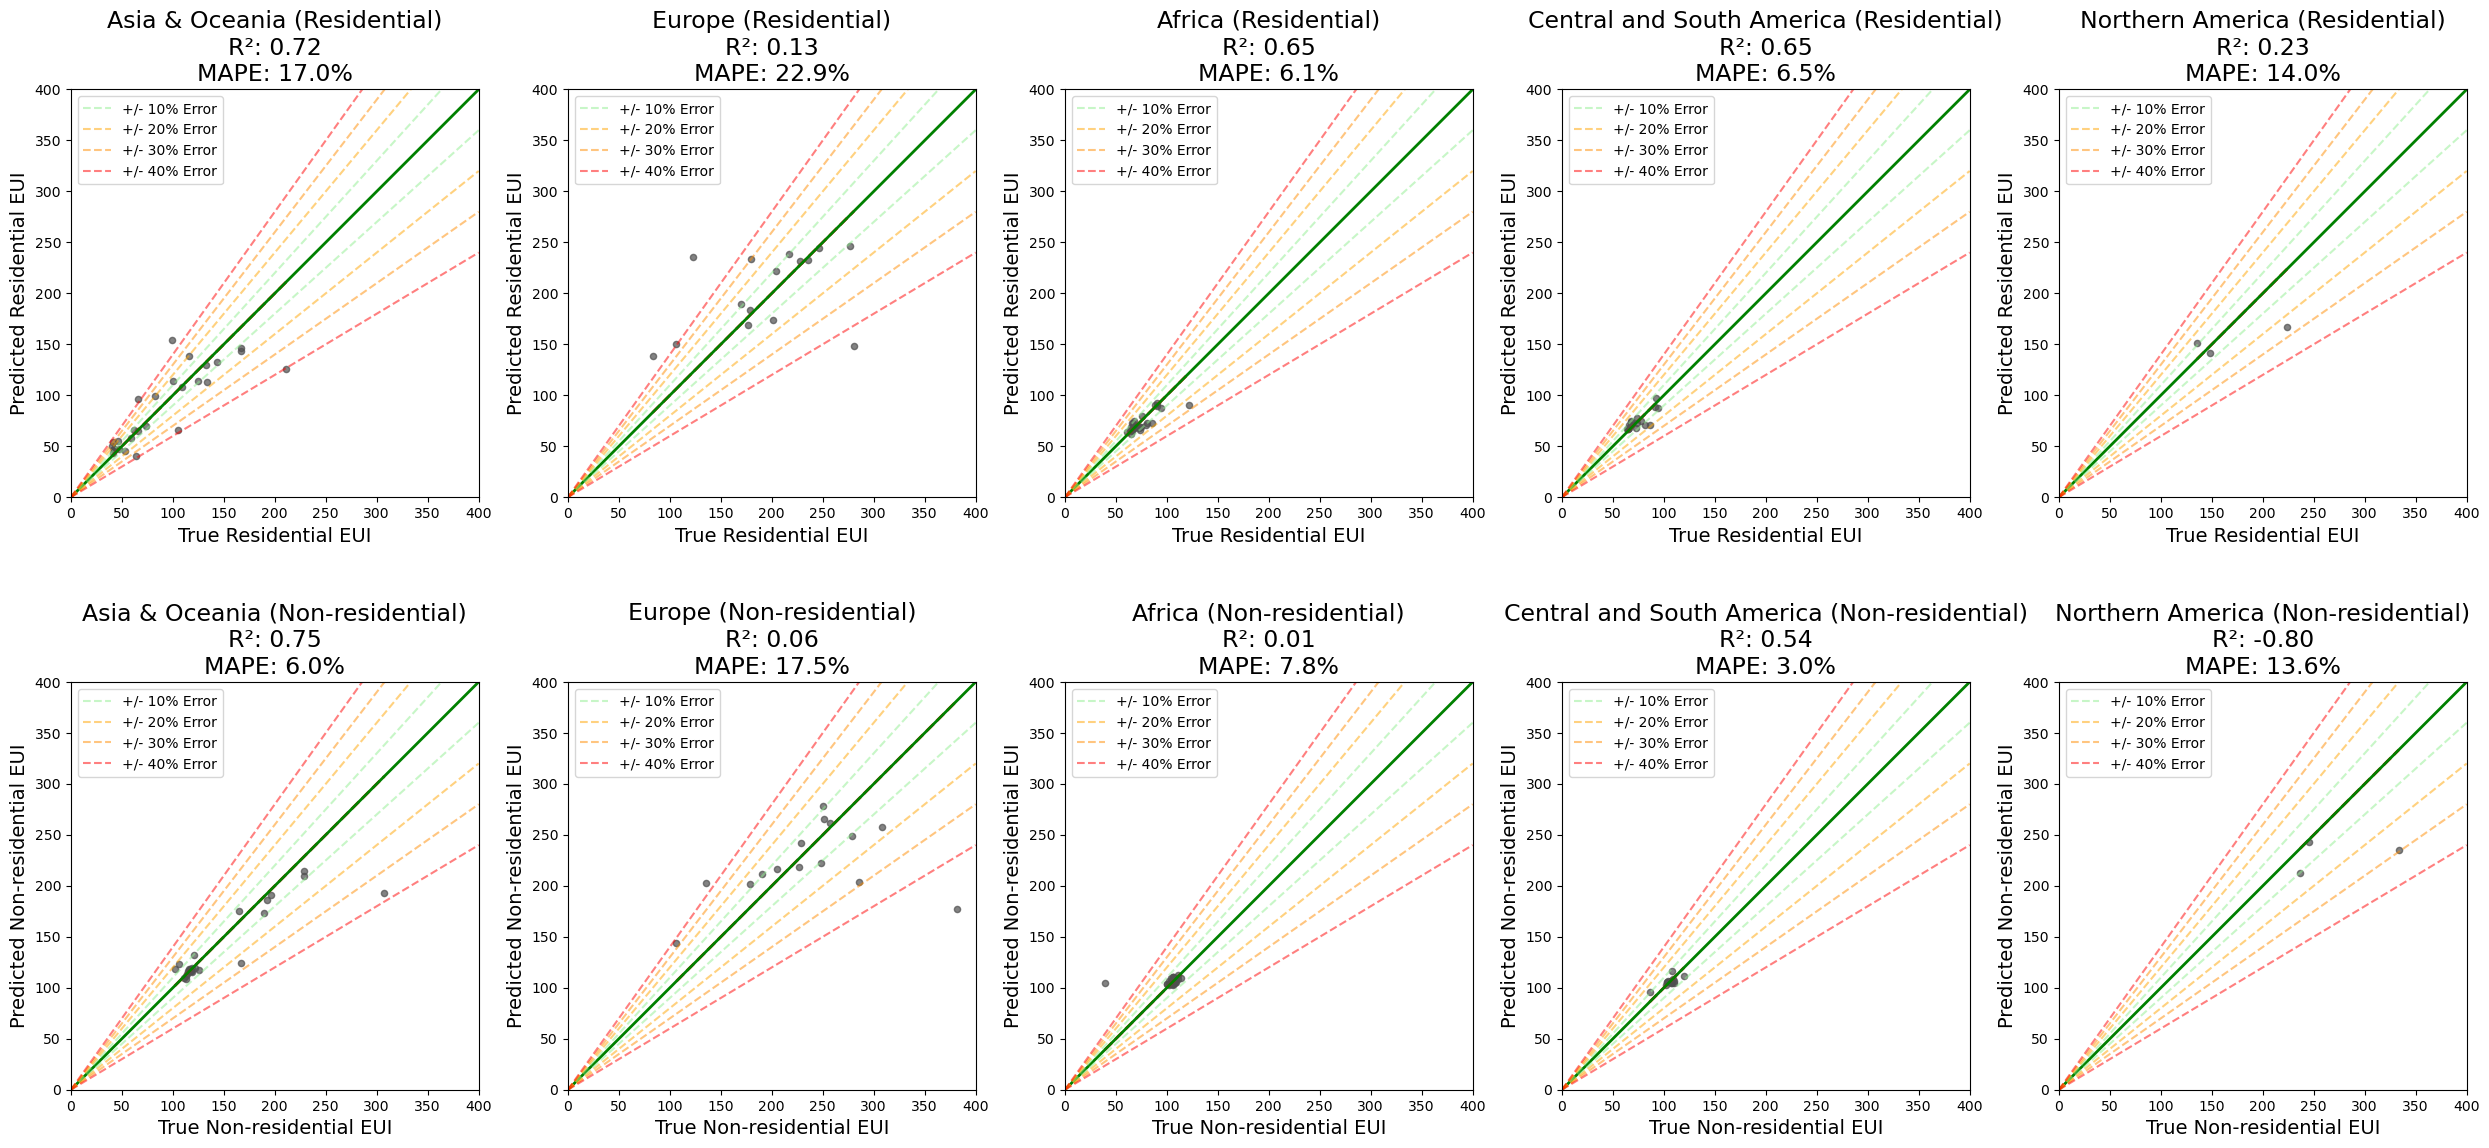

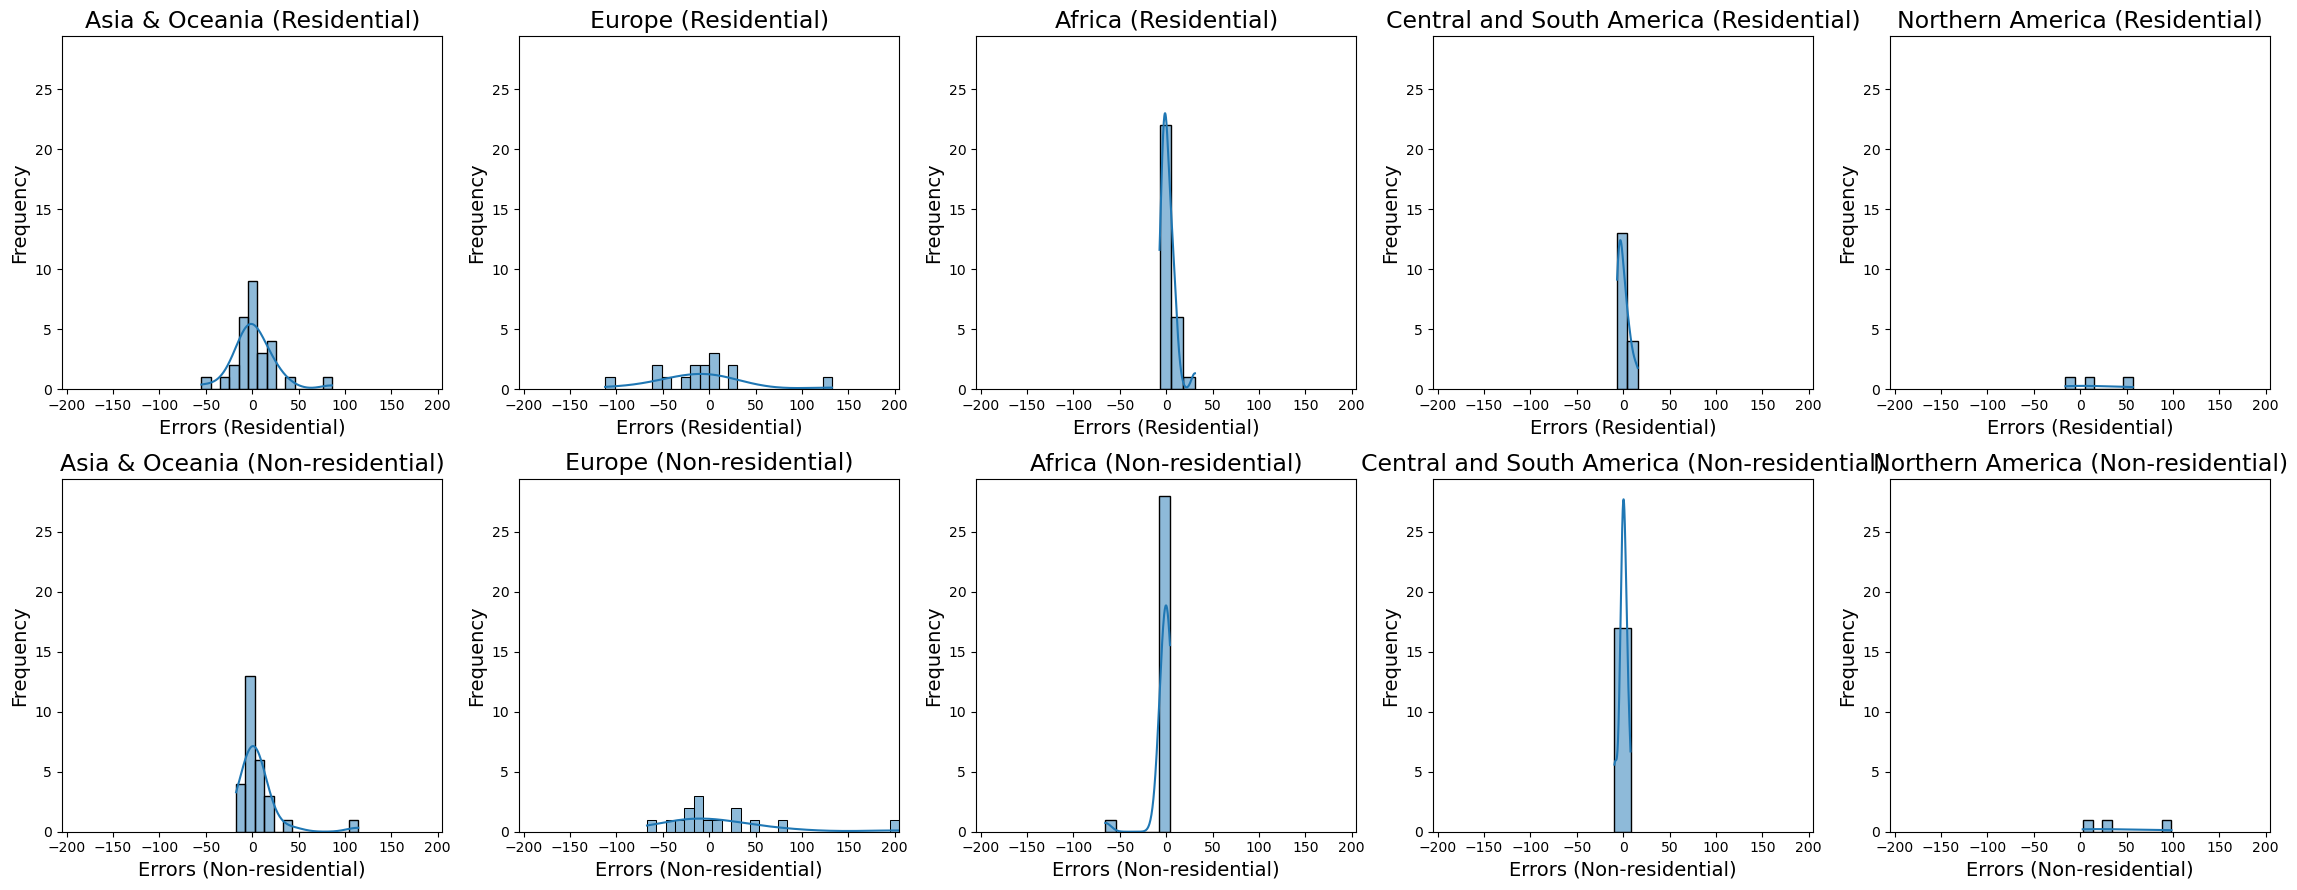

In [7]:
# Within Domain
model_cat_within = CatBoostRegressor(**cat_params)
results_cat_within = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_within,
    strategy='within_domain'
)

create_eui_comparison_plots(results_cat_within, 
    save_path='../figures/model_plots/cat_within_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_within,
    save_path='../figures/model_plots/cat_within_domain_error_distribution.png')

### CatBoost - Cross Domain

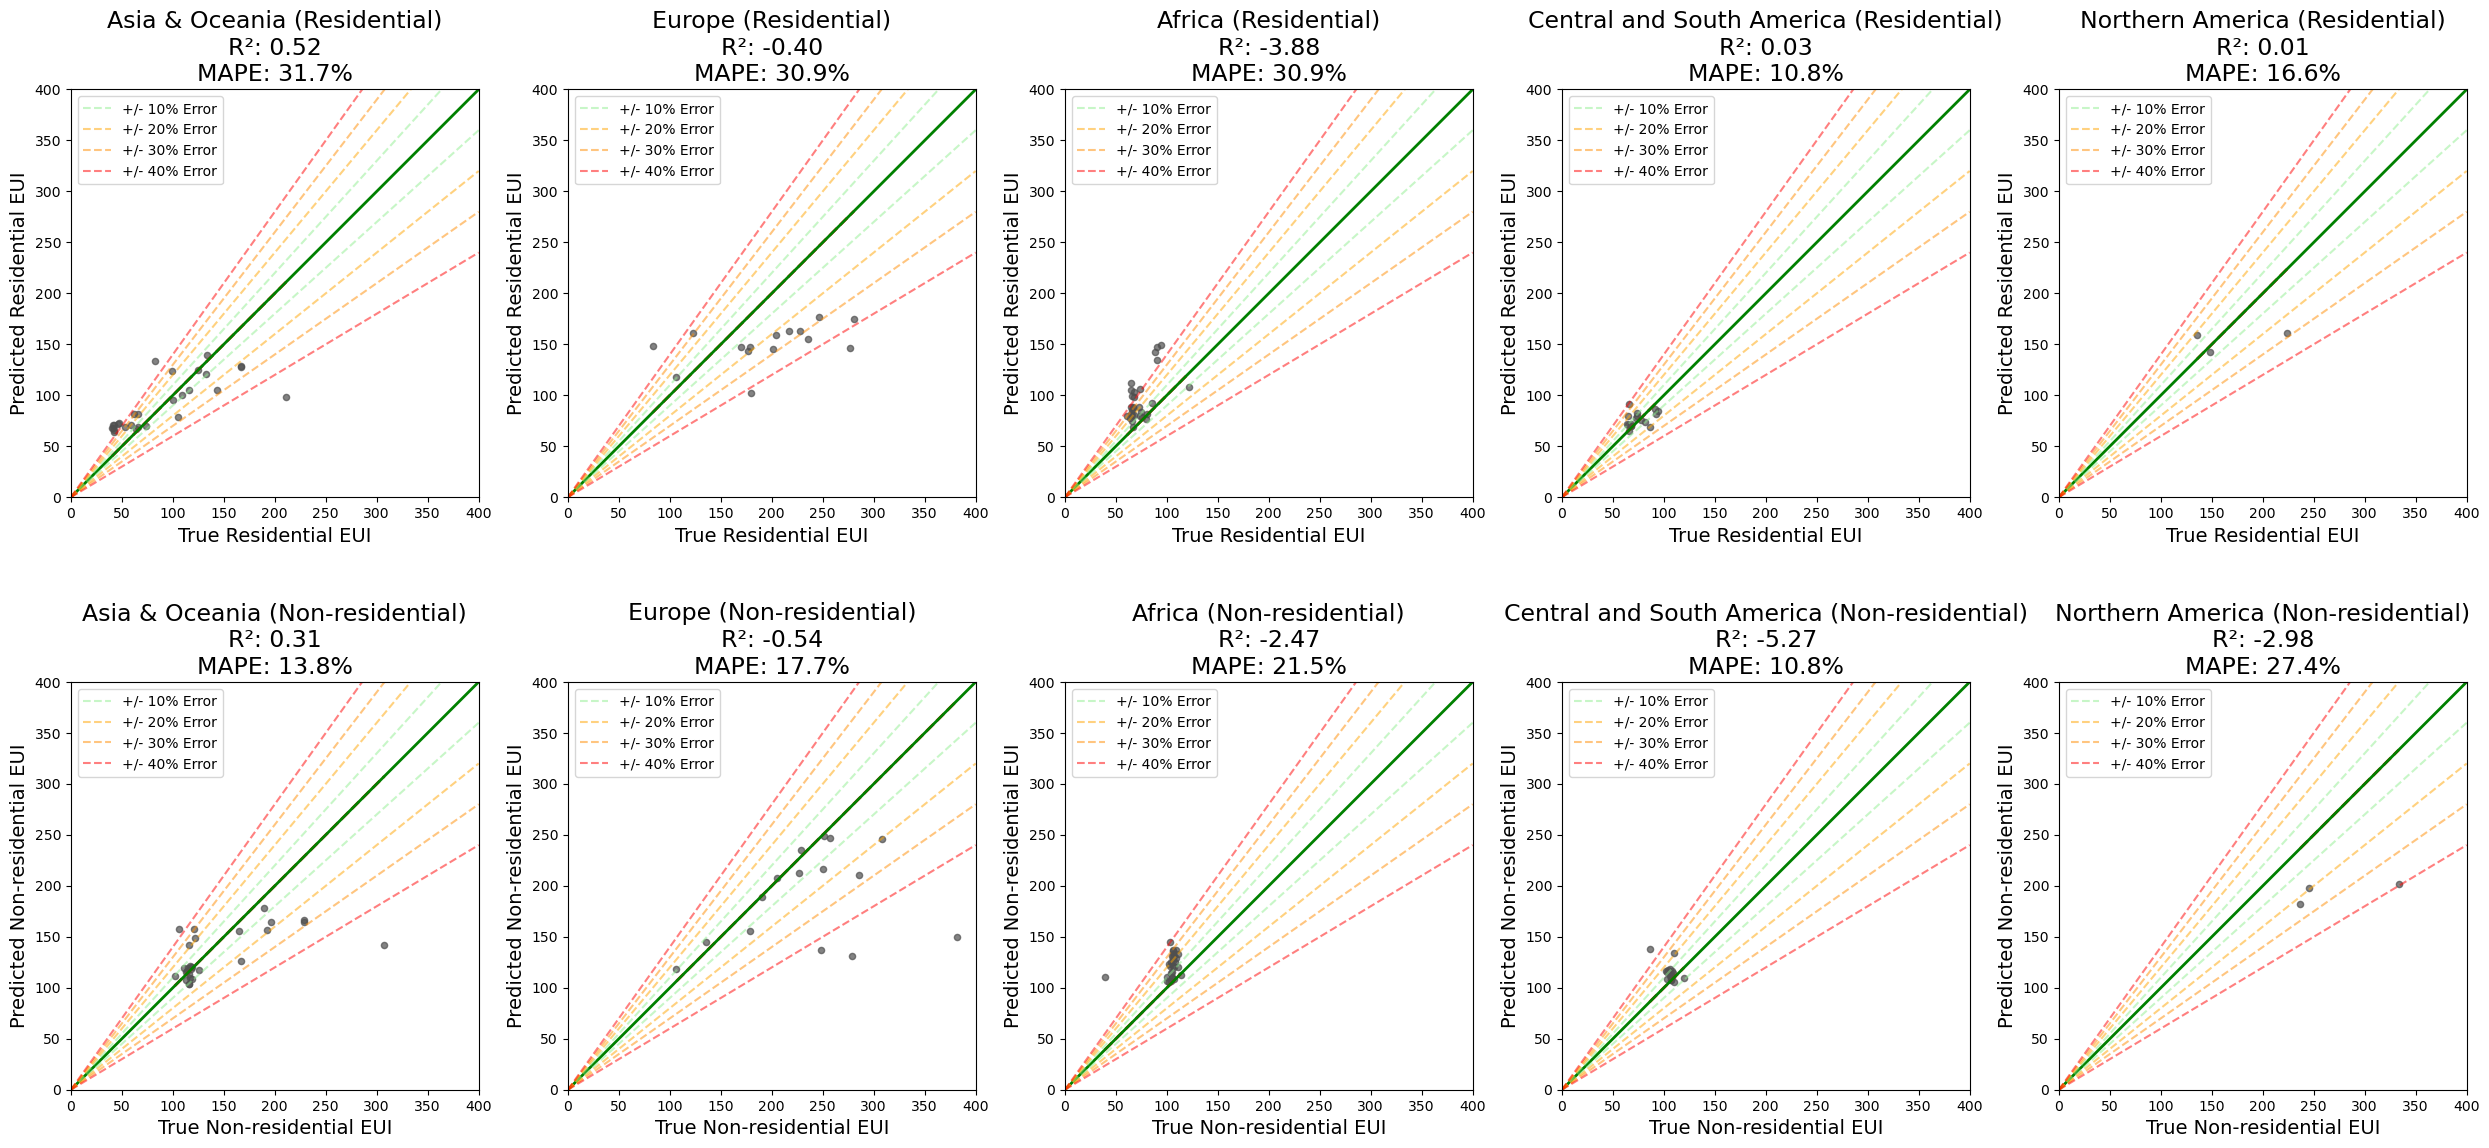

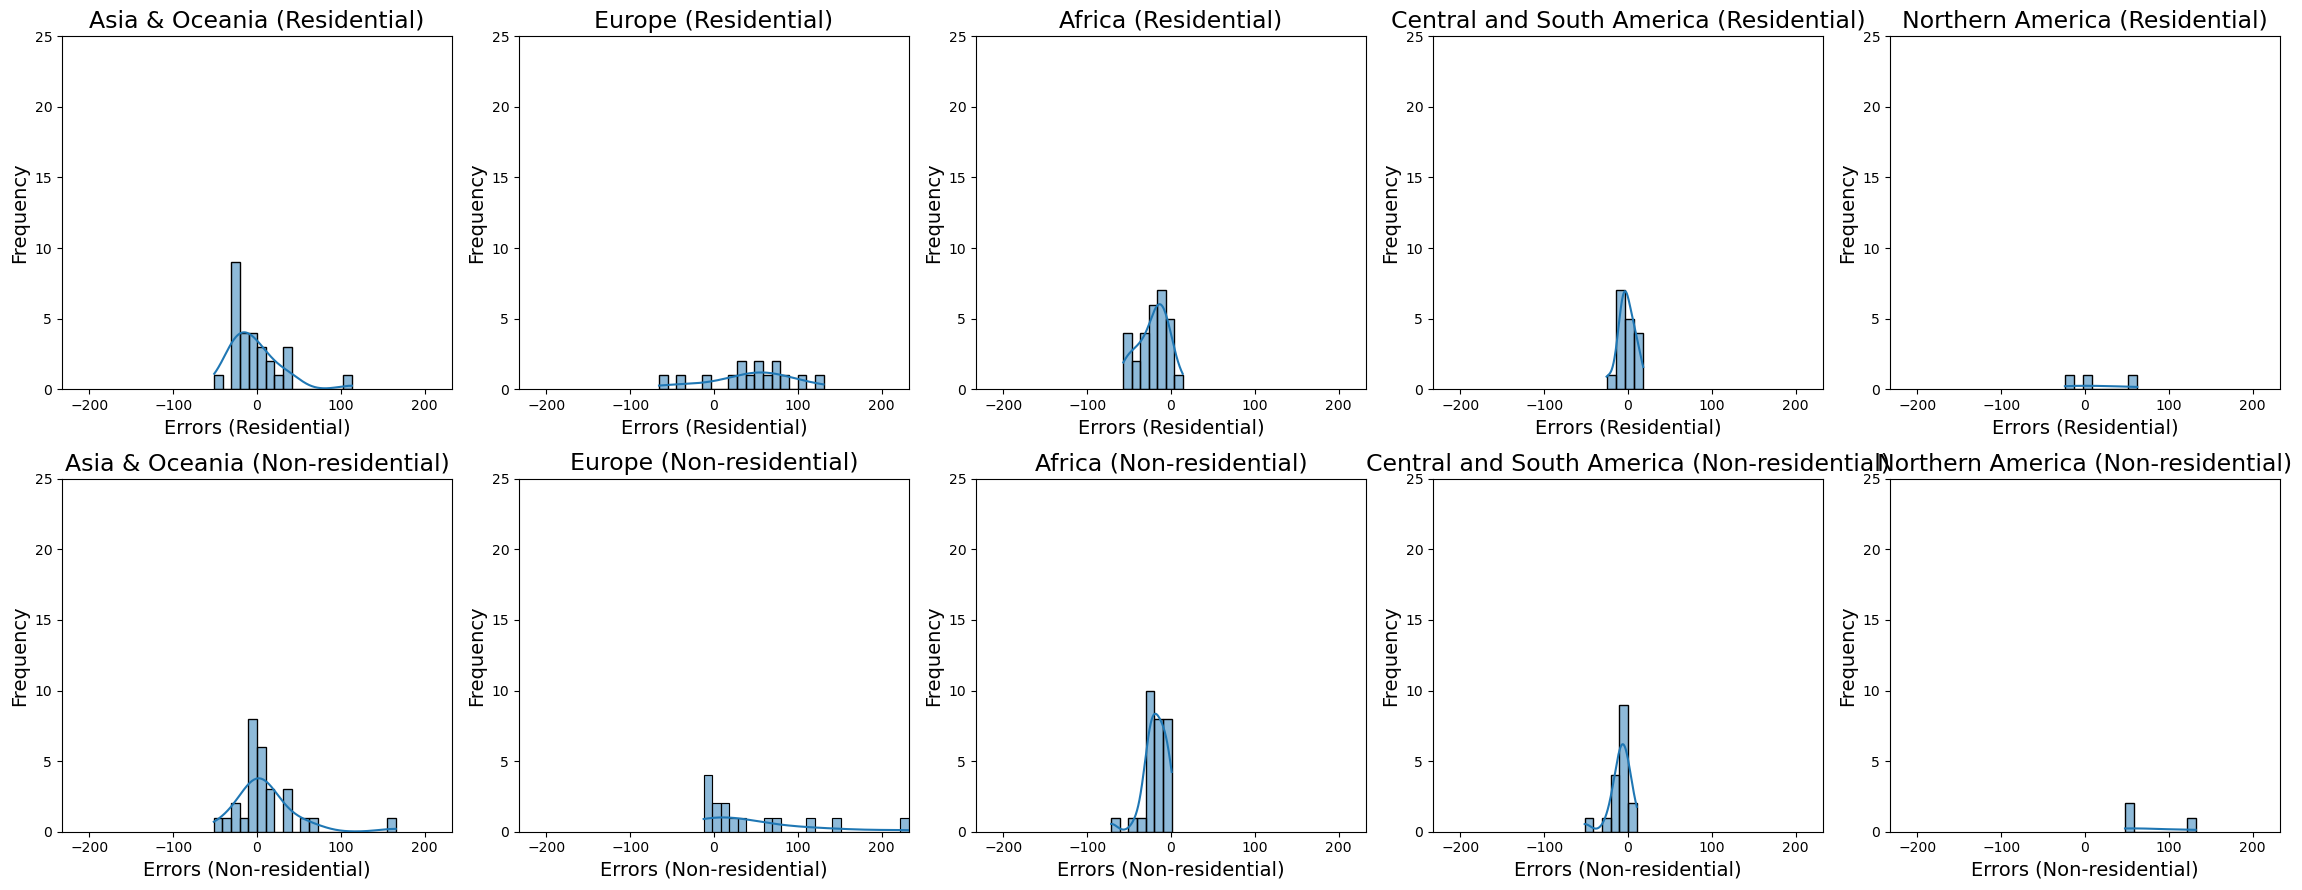

In [8]:
# Cross-domain
model_cat_cross = CatBoostRegressor(**cat_params)
results_cat_cross = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_cross,
    strategy='cross_domain'
)

create_eui_comparison_plots(results_cat_cross,
    save_path='../figures/model_plots/cat_cross_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_cross,
    save_path='../figures/model_plots/cat_cross_domain_error_distribution.png')


### CatBoost - All Domain

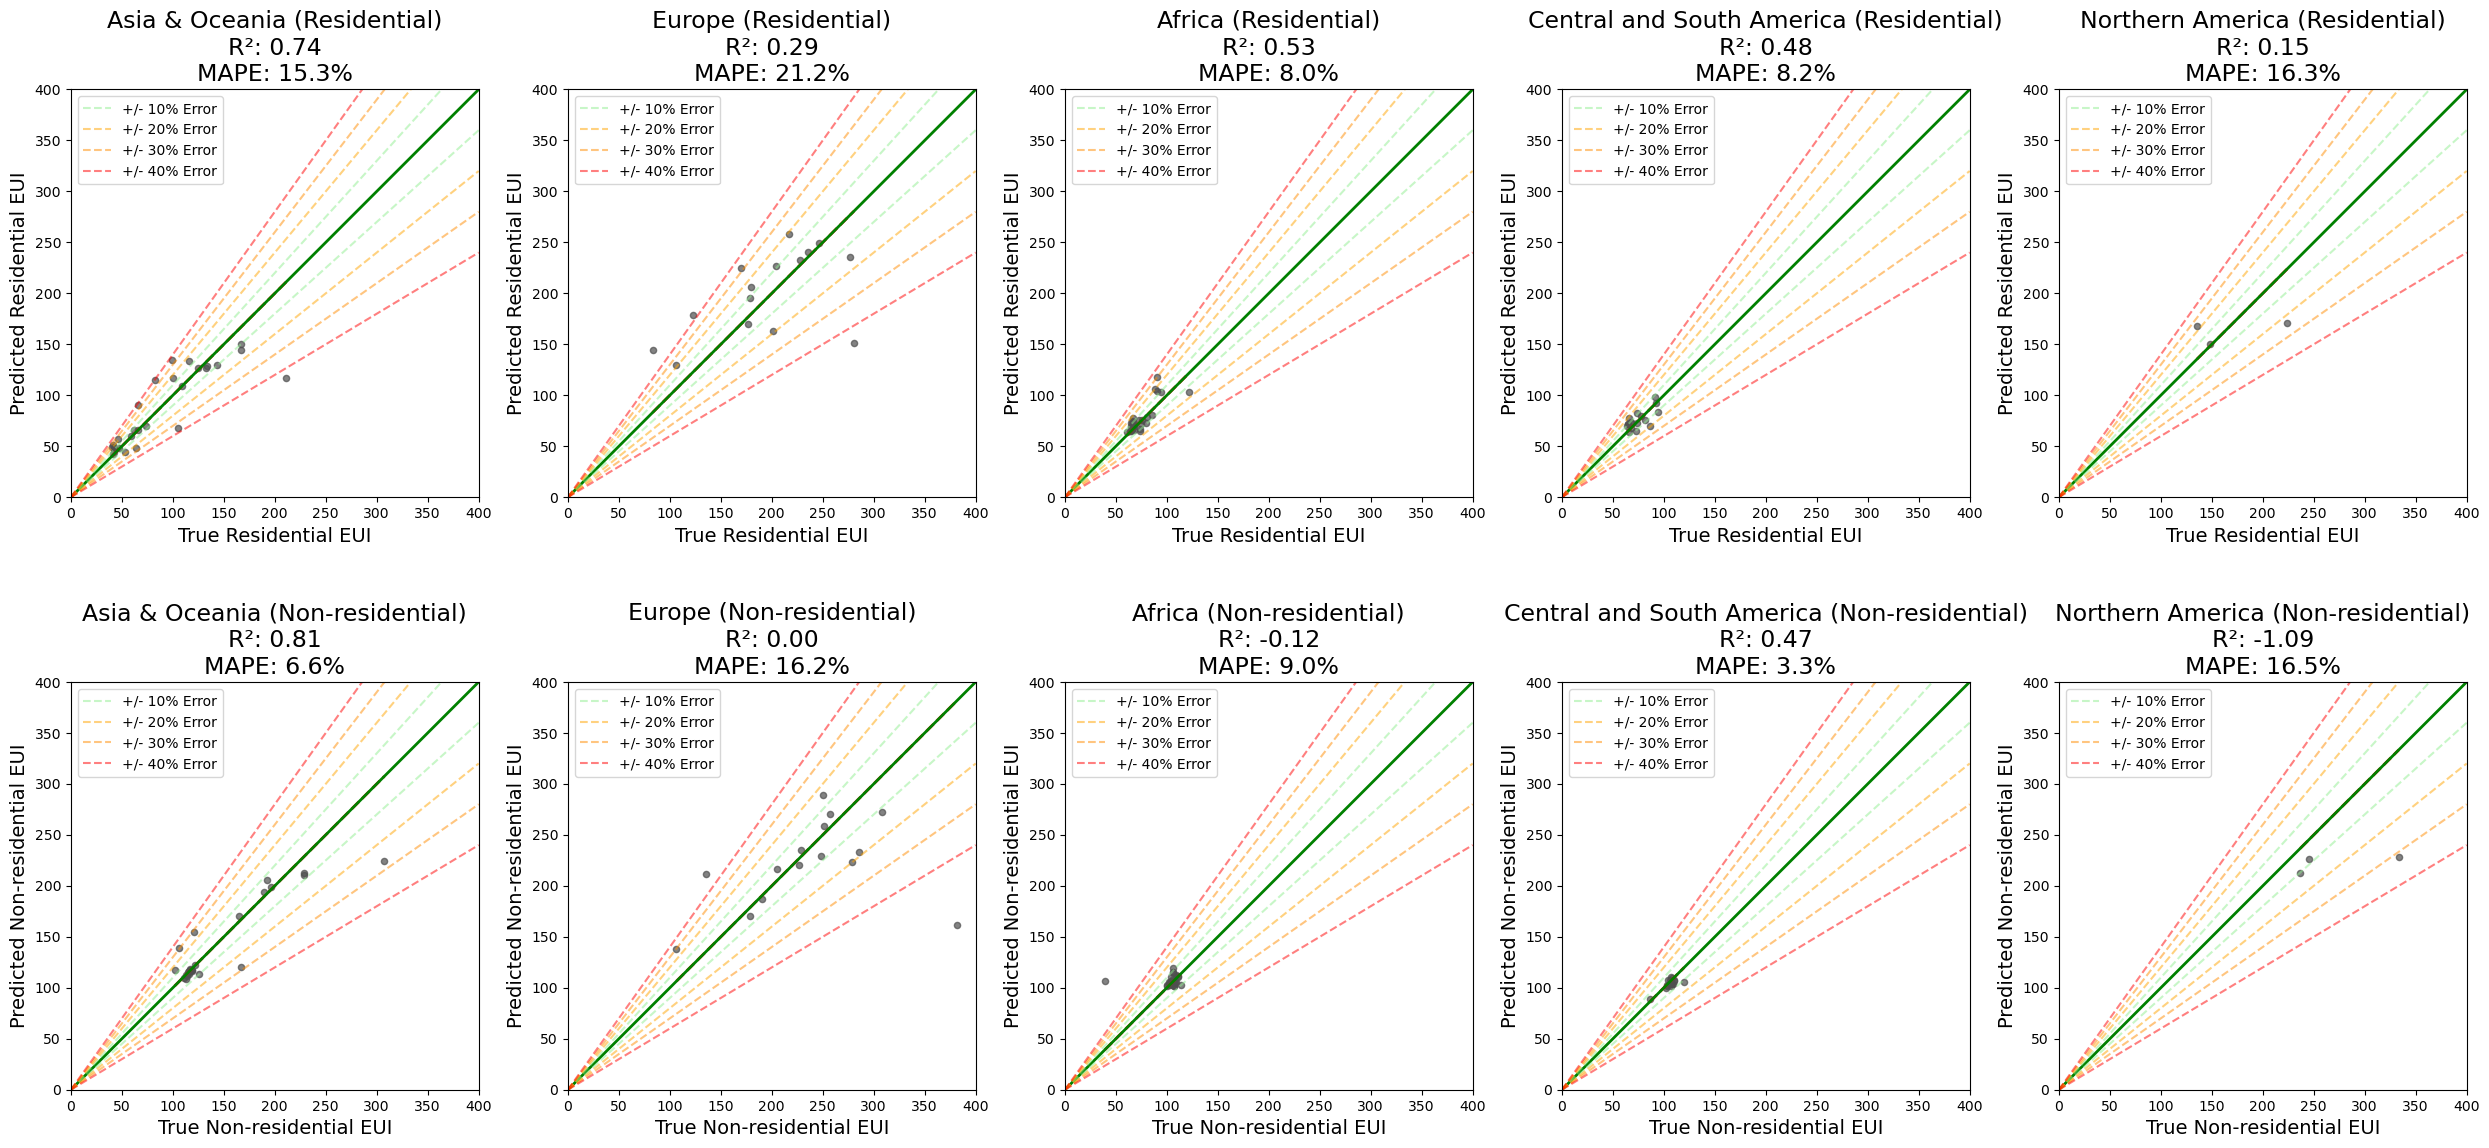

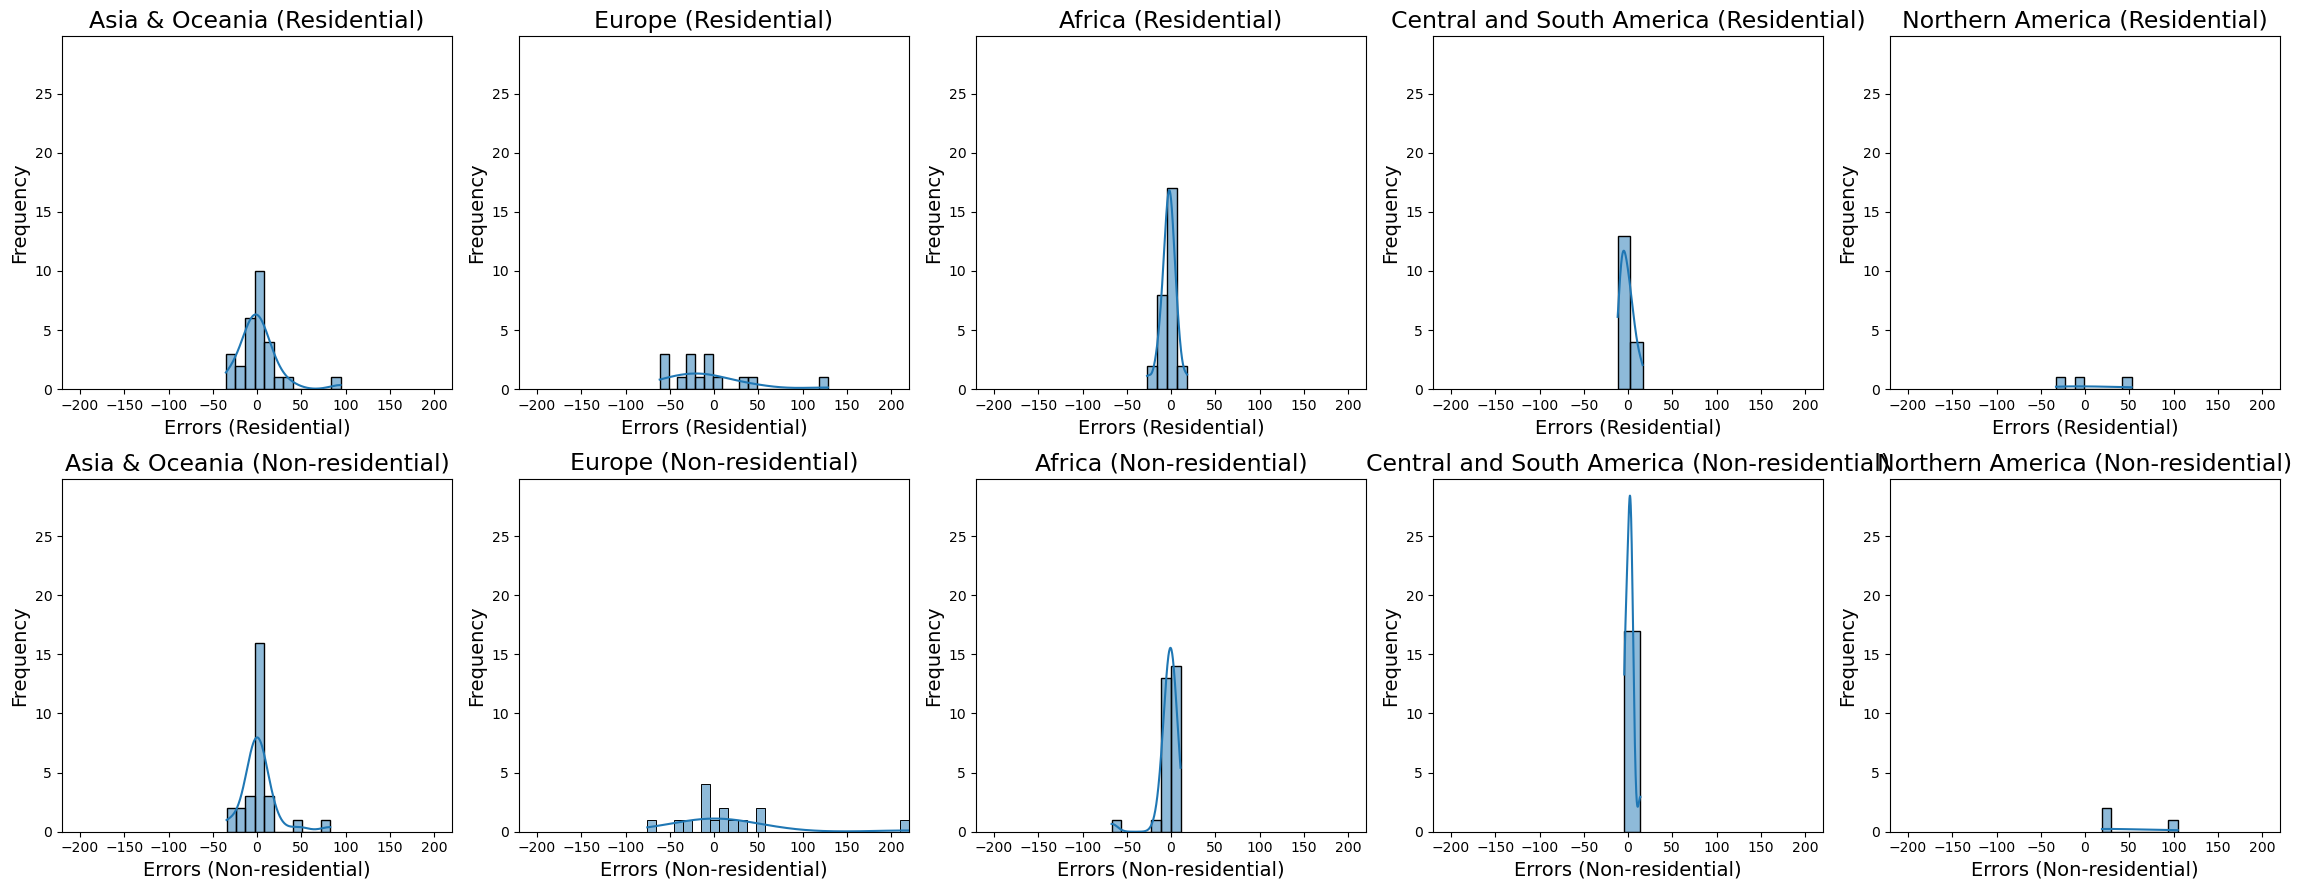

In [9]:
# All-domain
model_cat_all = CatBoostRegressor(**cat_params)
results_cat_all = train_and_evaluate_models(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model=model_cat_all,
    strategy='all_domain'
)

create_eui_comparison_plots(results_cat_all,
    save_path='../figures/model_plots/cat_all_domain_eui_predictions.png')

create_error_distribution_plots(results_cat_all,
    save_path='../figures/model_plots/cat_all_domain_error_distribution.png')

In [10]:
CatModel = lambda: CatBoostRegressor(**cat_params)

cat_detailed_results = evaluate_model_strategies(
    merged_df=merged_df,
    regions=regions,
    features=features,
    model_type=CatModel,   
    feature_abbreviations=feature_abbreviations,
    model_details=", ".join(f"{k}={v}" for k, v in cat_params.items())
)

cat_detailed_results['Model'] = 'CatBoostRegressor'

cat_average_results = calculate_average_metrics(cat_detailed_results).reset_index()
cat_average_results

,Target,Strategy,Model,Model Details,Features Used,Features Abbreviated,MAPE,R²,MSE,RMSE,MAE,WAPE
0,Non-residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations=300, verbose=False","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,9.58,0.111,1652.540,32.705,20.320,9.56
1,Non-residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations=300, verbose=False","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,18.24,-2.190,3334.141,49.665,36.098,18.88
2,Non-residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations=300, verbose=False","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,10.32,0.013,1789.107,33.585,21.715,10.24
3,Residential EUI (kWh/m2/year),within_domain,CatBoostRegressor,"iterations=300, verbose=False","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,13.30,0.476,917.788,24.885,17.592,13.02
4,Residential EUI (kWh/m2/year),cross_domain,CatBoostRegressor,"iterations=300, verbose=False","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,24.18,-0.744,1563.766,35.063,28.840,23.32
5,Residential EUI (kWh/m2/year),all_domain,CatBoostRegressor,"iterations=300, verbose=False","hdd_total_year, cdd_total_year, GDP_per_capita...",HDD | CDD | GDP | URB | Paris | HDI | EDU | In...,13.80,0.436,842.727,24.602,18.288,13.68


In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
cat_detailed_results.to_csv(f'../results/{timestamp}_cat_detailed_results.csv')
cat_average_results.to_csv(f'../results/{timestamp}_cat_average_results.csv')

# 